In [2]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
pd.set_option('display.max_rows', 10)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from sklearn.cluster import KMeans

In [1]:
CARS = [
    ('toyota', 'yaris'),
    ('honda', 'jazz'),
    ('suzuki', 'swift'),
    ('citroen', 'c1'),
    ('peugeot', '107'),
    ('toyota', 'aygo'),
    ('citroen', 'c4'),
    ('renault', 'clio'), 
]

ALL_FOLDER = "./all"
ALL_MERGED_PATH = "all_merged_offers.csv"
LOCATION = "gdansk"
LOCALIZED_FOLDER = f"./{LOCATION}"
LOCALIZED_PATH = f"{LOCATION}_merged_offers.csv"
RADIUS = "100"
PRICE_TOP_LIMIT = 30000



polish_months = {
    "stycznia": "01", "lutego": "02", "marca": "03", "kwietnia": "04",
    "maja": "05", "czerwca": "06", "lipca": "07", "sierpnia": "08",
    "września": "09", "października": "10", "listopada": "11", "grudnia": "12"
}

In [3]:
class Offer:
    def __init__(self, title, price, year_mileage, url=None, date=None):
        self.title = title
        self.price = self.parse_price(price)
        self.year, self.mileage = self.parse_year_mileage(year_mileage)
        self.url = url
        self.date = self.parse_date(date) 

    def parse_price(self, price_str):
        price_digits = re.sub(r'[^\d]', '', price_str)
        return int(price_digits) if price_digits else None

    def parse_year_mileage(self, text):
        try:
            parts = text.split('-')
            year = int(parts[0].strip()) if parts else None
            mileage_match = re.search(r'(\d[\d\s]*)\s*km', text)
            mileage = int(mileage_match.group(1).replace(' ', '')) if mileage_match else None
            return year, mileage
        except Exception:
            return None, None
        
    def parse_date(self, raw_date_text):
        """
        Parses OLX date strings like:
        - 'Wrocław, Fabryczna - Dzisiaj o 11:04'
        - 'Ostróda - Odświeżono dnia 07 lipca 2025'
        """
        try:
            raw_date_text = raw_date_text.lower()

            if "dzisiaj" in raw_date_text:
                return datetime.today().date()
            if "wczoraj" in raw_date_text:
                return (datetime.today() - timedelta(days=1)).date()

            # Extract e.g. "07 lipca 2025"
            match = re.search(r'(\d{1,2}) (\w+) (\d{4})', raw_date_text)
            if not match:
                print(f"ERROR: COULD NOT MATCH '{raw_date_text}'")
                return None

            day, month_name, year = match.groups()
            month = polish_months.get(month_name.lower())
            if not month:
                print(f"ERROR: Unknown month '{month_name}'")
                return None

            date_str = f"{year}-{month}-{int(day):02d}"
            return datetime.strptime(date_str, "%Y-%m-%d").date()

        except Exception as e:
            print("ERROR parsing date:", e)
            return None

    def to_dict(self):
        return {
            'title': self.title,
            'price': self.price,
            'year': self.year,
            'mileage': self.mileage,
            'url': self.url,
            'date': str(self.date) if self.date else None
        }

    def __str__(self):
        return f"{self.title} | {self.price} PLN | {self.year} | {self.mileage} km"

In [4]:

def scrape_offers(base_url, max_pages=None):
    headers = {'User-Agent': 'Mozilla/5.0'}
    page = 1
    seen_urls = set()         # For detecting duplicate offers across pages
    all_offers = list()

    print(f"🚗 Starting scrape: {base_url}")
    while True:
        url = f"{base_url}&page={page}"
        print(f"\n🔎 Scraping page {page}: {url}")
    
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"⚠️ Failed to fetch page {page}, status code: {response.status_code}")
            break

        soup = BeautifulSoup(response.text, 'html.parser')
        offers = soup.find_all('div', class_='css-1apmciz')

        if not offers:
            print("⚠️ No listings found. Ending scrape.")
            break

        new_offers_this_page = 0
        for offer in offers:
            try:
                title_tag = offer.find('h4', class_='css-1g61gc2')
                title = title_tag.text.strip() if title_tag else "No title"

                price_tag = offer.find('p', {'data-testid': 'ad-price'})
                price = price_tag.text.strip() if price_tag else "No price"

                ym_tag = offer.find('div', class_='css-1kfqt7f')
                year_mileage = ym_tag.get_text(strip=True) if ym_tag else "No year/mileage"

                url_tag = offer.find('a', href=True)
                raw_href = url_tag['href'] if url_tag else None
                offer_url = raw_href if raw_href.startswith("http") else "https://www.olx.pl" + raw_href
                
                date_tag = offer.find('p', {'data-testid': 'location-date'})
                date_text = date_tag.text.strip() if date_tag else "No date"

                # Skip if we've already seen this offer URL
                if offer_url in seen_urls:
                    print(f"🔁 Duplicate offer skipped: {offer_url}")
                    continue
                seen_urls.add(offer_url)
                new_offers_this_page += 1
                    
                offer_obj = Offer(title, price, year_mileage, url=offer_url, date=date_text)
                all_offers.append(offer_obj)

                print(f"✅ {offer_obj}")

            except Exception as e:
                print("❌ Error parsing offer:", e)

        if new_offers_this_page == 0:
            print("🛑 All offers on this page were duplicates. Ending scrape.")
            break
        page += 1
        if max_pages and page > max_pages:
            print(f"⏹ Reached max_pages limit: {max_pages}")
            break

        time.sleep(1)  # Be polite to OLX servers

    print(f"\n✅ Done scraping {len(all_offers)} listings from {base_url}\n")
    return all_offers


In [5]:
def build_olx_url(brand, model, location=None, radius=None):
    base = f"https://www.olx.pl/motoryzacja/samochody/{brand}/"
    # Specify location of the offers:
    if location:
        base += f"{location}/"
    base += f"?search%5Bfilter_enum_model%5D%5B0%5D={model}"
    if radius and location:
        base += f"&search%5Bdist%5D={radius}"
    # Look for not petrol engine damaged cars:
    base += "&search%5Bfilter_enum_condition%5D%5B0%5D=notdamaged&search%5Bfilter_enum_petrol%5D%5B0%5D=petrol"
    return base

In [6]:
for brand_model in CARS:
    brand = brand_model[0]
    model = brand_model[1]
    # URLs for global and local scrapes
    url_all_cars = build_olx_url(brand, model)
    url_localized_cars = build_olx_url(brand, model, LOCATION, RADIUS)

    # Scrape ALL cars first
    all_cars_offers = scrape_offers(url_all_cars)
    # Scrape only localized cars
    localized_offers = scrape_offers(url_localized_cars)

    # Save results
    os.makedirs("all", exist_ok=True)
    pd.DataFrame([o.to_dict() for o in all_cars_offers]).to_csv(f"all/{brand}_{model}_olx.csv", index=False, encoding='utf-8-sig')
    print(f"📁 All cars data saved to all/{brand}_{model}_olx.csv")

    os.makedirs(f"{LOCATION}", exist_ok=True)
    pd.DataFrame([o.to_dict() for o in localized_offers]).to_csv(f"{LOCATION}/{brand}_{model}_olx.csv", index=False, encoding='utf-8-sig')
    print(f"📁 {LOCATION} cars data saved to {LOCATION}/{brand}_{model}_olx.csv")

🚗 Starting scrape: https://www.olx.pl/motoryzacja/samochody/toyota/?search%5Bfilter_enum_model%5D%5B0%5D=yaris&search%5Bfilter_enum_condition%5D%5B0%5D=notdamaged&search%5Bfilter_enum_petrol%5D%5B0%5D=petrol

🔎 Scraping page 1: https://www.olx.pl/motoryzacja/samochody/toyota/?search%5Bfilter_enum_model%5D%5B0%5D=yaris&search%5Bfilter_enum_condition%5D%5B0%5D=notdamaged&search%5Bfilter_enum_petrol%5D%5B0%5D=petrol&page=1
✅ Toyota Yaris Toyota Yaris Hybryda, | 26000 PLN | 2012 | 161000 km
✅ Toyota Yaris 1.3 benzyna, 2008 r. | 9900 PLN | 2008 | 252166 km
✅ Toyota Yaris 1.3benzyna 2006r klimatyzacja  bez rdzy w pełni sprawna | 9300 PLN | 2006 | 240000 km
✅ Toyota Yaris II 1.3 2008 automat | 13900 PLN | 2008 | 176822 km
✅ Toyota Yaris_1,33_6-biegów_Klimatyzacja | 16800 PLN | 2009 | 124000 km
✅ Toyota Yaris | 38000 PLN | 2016 | 62000 km
✅ Śliczna Toyota Yaris 2021r jak nowa 21tys! Wyś-3D ! Led! Kamera! Full! | 51900 PLN | 2021 | 21762 km
✅ TOYOTA Yaris 1,3 100KM DUAL 5-Drzwi Klimatyzacja | 1

In [3]:
def merge_csv_folder(foler_path, output_name):
    dfs = list()
    for out_csv in os.listdir(foler_path):
        df = pd.read_csv(os.path.join(foler_path, out_csv), encoding="utf-8-sig")
        # Extract brand_model from filename
        base = os.path.basename(out_csv)            # e.g. "toyota_yaris_olx.csv"
        brand_model = base.replace("_olx.csv", "")  # e.g. "toyota_yaris"
        # Add column10000
        df["brand_model"] = brand_model
        # Append to list
        dfs.append(df)
    # Merge all DataFrames
    merged_df = pd.concat(dfs, ignore_index=True)
    # Save to new CSV if you like
    merged_df.to_csv(f"{output_name}", index=False, encoding="utf-8-sig")

merge_csv_folder(ALL_FOLDER, ALL_MERGED_PATH)
merge_csv_folder(LOCALIZED_FOLDER, LOCALIZED_PATH)

In [4]:
# Filter out offers
df = pd.read_csv(f"{ALL_MERGED_PATH}")

# Drop rows without price/year
df = df.dropna(subset=["price", "year"])

# Fix mileage likely expressed without thousands
df.loc[(df["mileage"] > 1) & (df["mileage"] < 1000), "mileage"] = (df["mileage"] * 1000)
df.loc[(df["mileage"] > 1000000), "mileage"] = (df["mileage"] / 10).astype(int)
# Remove unreasonable values
df = df[(df["mileage"] >= 2) & (df["price"] >= 1000) & (df["price"] <= 15000) & (df["year"] >= 2005) & (df["year"] <= 2015)]
df["discount"] = ""

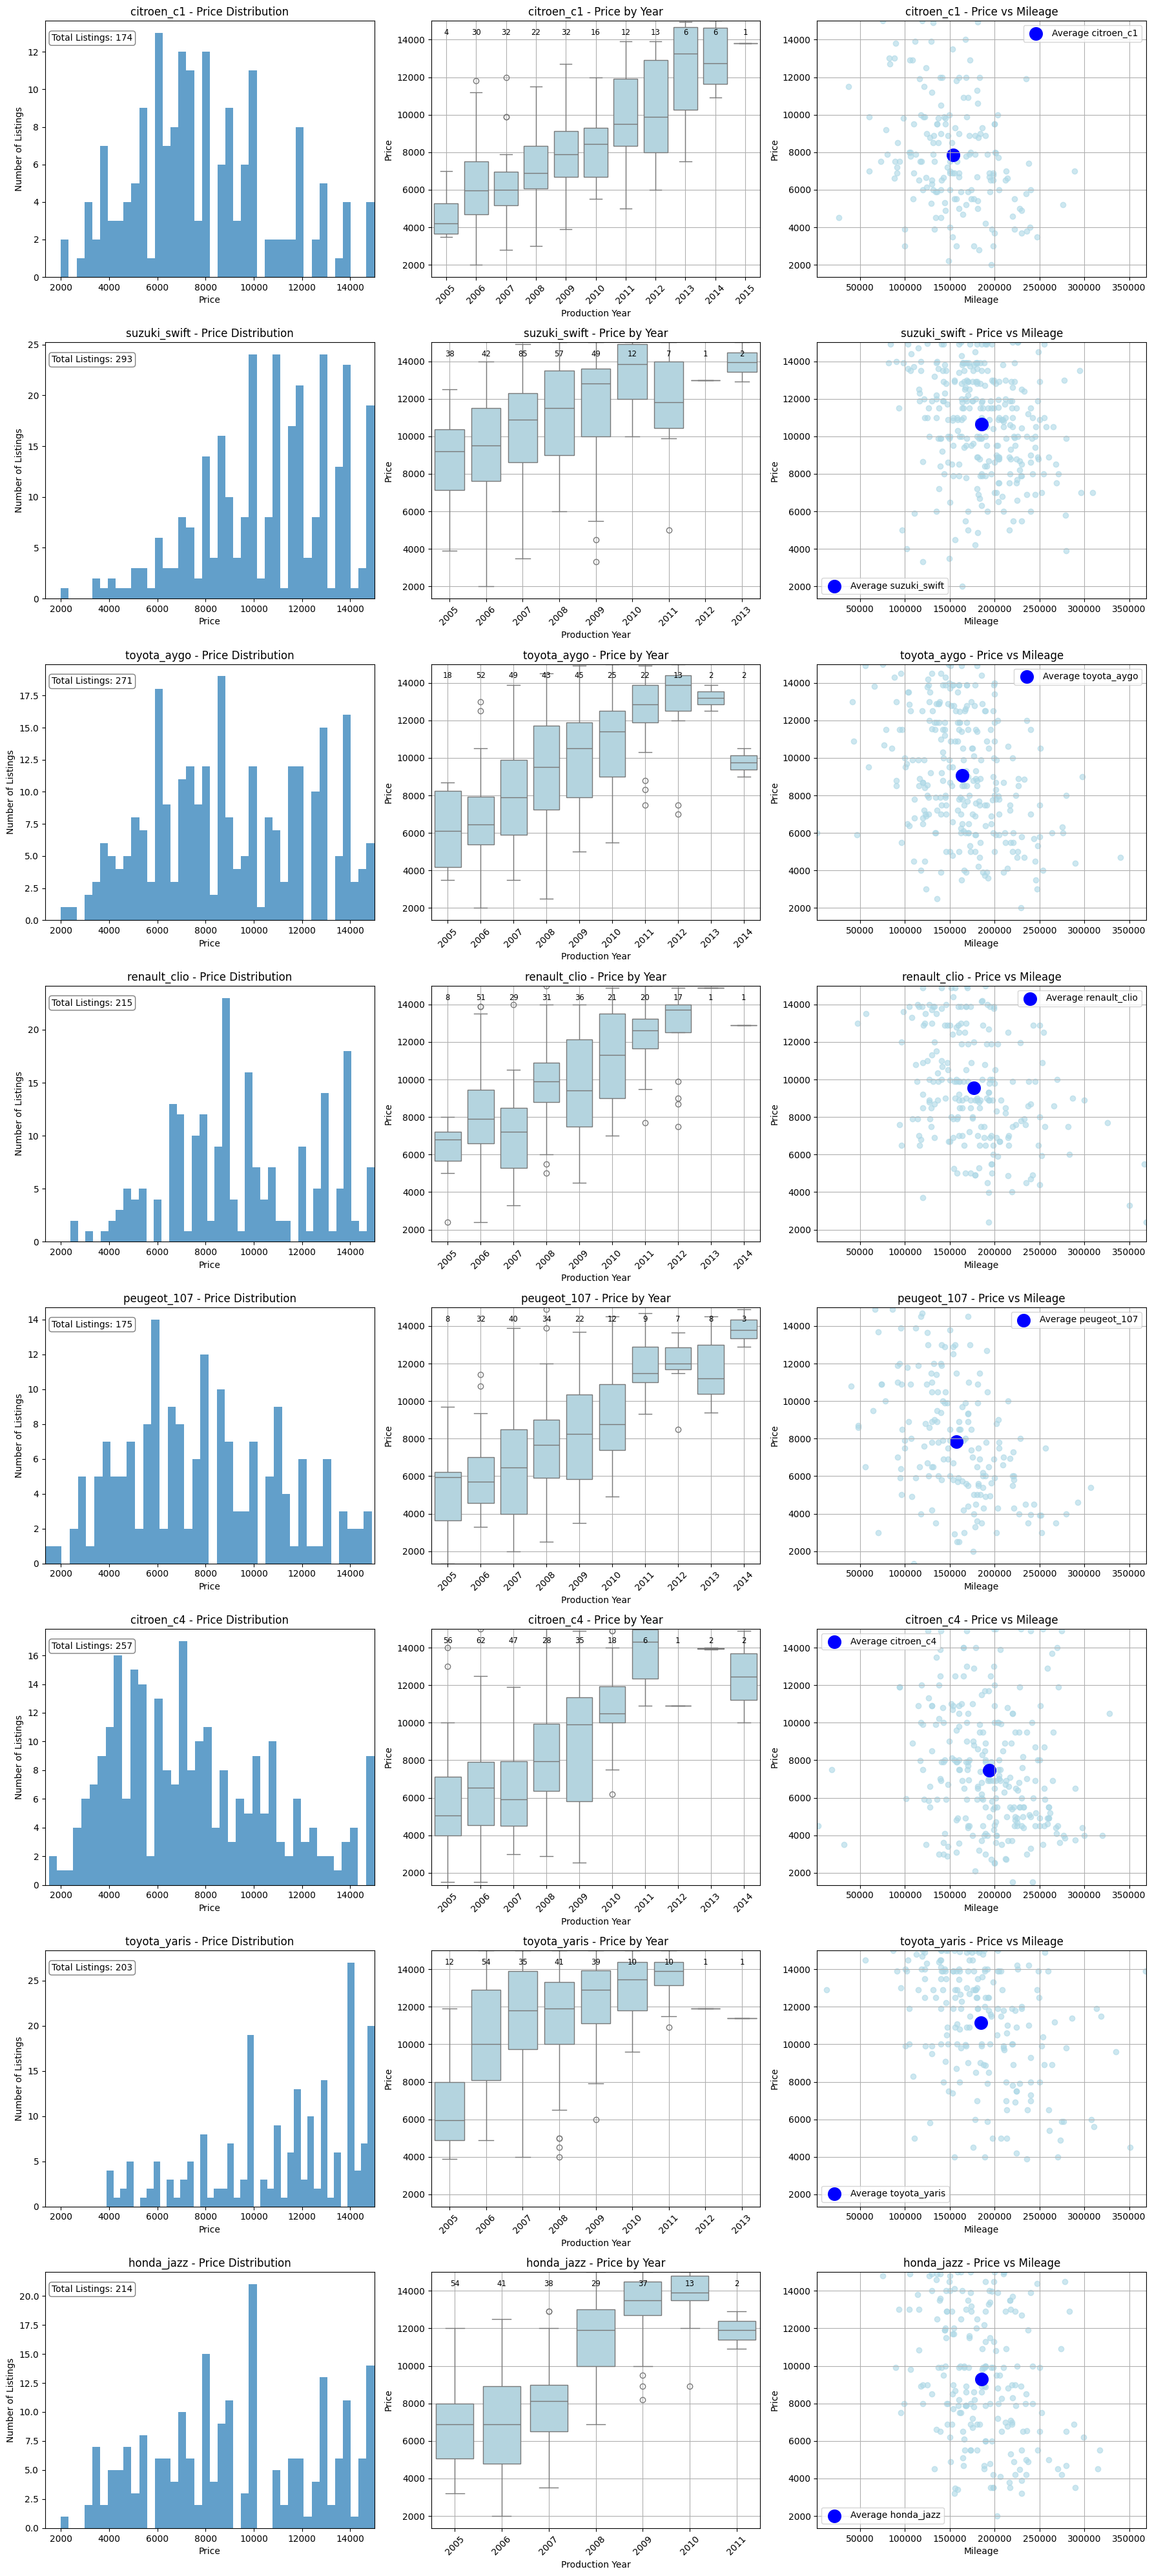

In [5]:
# Determine global min and max for price and mileage
global_price_min = df['price'].min()
global_price_max = df['price'].max()
global_mileage_min = df['mileage'].min()
global_mileage_max = df['mileage'].max()

brand_models = df['brand_model'].unique()
n_brands = len(brand_models)

fig, axs = plt.subplots(
    nrows=n_brands, ncols=3,
    figsize=(18, 5 * n_brands)
)

# If only 1 brand, axs is 1D, so force to 2D array for consistency
if n_brands == 1:
    axs = axs[np.newaxis, :]

for i, brand_model in enumerate(brand_models):
    subset = df[df['brand_model'] == brand_model]

    # 1) Histogram
    axs[i, 0].hist(
        subset['price'],
        bins=40,
        alpha=0.7,
        color="tab:blue"
    )
    axs[i, 0].set_xlabel('Price')
    axs[i, 0].set_ylabel('Number of Listings')
    axs[i, 0].set_title(f'{brand_model} - Price Distribution')
    axs[i, 0].set_xlim(global_price_min, global_price_max)  # Set consistent x-axis limits

    # Add text in upper left corner
    axs[i, 0].text(
        0.02, 0.95,
        f'Total Listings: {len(subset)}',
        transform=axs[i, 0].transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
    )

    # 2) Boxplot by year
    sns.boxplot(
        data=subset,
        x='year',
        y='price',
        ax=axs[i, 1],
        color="lightblue"
    )
    axs[i, 1].tick_params(axis='x', rotation=45)
    axs[i, 1].set_xlabel('Production Year')
    axs[i, 1].set_ylabel('Price')
    axs[i, 1].set_title(f'{brand_model} - Price by Year')
    axs[i, 1].grid(True)
    axs[i, 1].set_ylim(global_price_min, global_price_max)  # Set consistent y-axis limits

    # Annotate number of offers for each year
    year_counts = subset['year'].value_counts()
    for tick, label in zip(axs[i, 1].get_xticks(), axs[i, 1].get_xticklabels()):
        year = int(label.get_text())
        count = year_counts.get(year, 0)
        axs[i, 1].text(
            tick, global_price_max * 0.95,  # Position text slightly below the top
            f'{count}',
            horizontalalignment='center',
            size='small',
            color='black'
        )

    # 3) Scatter plot mileage vs price with clustering
    X = subset[['mileage', 'price']].values
    kmeans = KMeans(n_clusters=1, random_state=0).fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    scatter = axs[i, 2].scatter(
        subset['mileage'],
        subset['price'],
        c='lightblue',  # Set color to light blue
        alpha=0.6
    )
    axs[i, 2].set_xlabel('Mileage')
    axs[i, 2].set_ylabel('Price')
    axs[i, 2].set_title(f'{brand_model} - Price vs Mileage')
    axs[i, 2].grid(True)
    axs[i, 2].set_xlim(global_mileage_min, global_mileage_max)  # Set consistent x-axis limits
    axs[i, 2].set_ylim(global_price_min, global_price_max)  # Set consistent y-axis limits

    # Plot cluster centers
    axs[i, 2].scatter(
        centers[:, 0], centers[:, 1],
        s=200, c='blue', marker='o',
        label=f'Average {brand_model}'
    )
    axs[i, 2].legend()

plt.tight_layout()
plt.show()

In [17]:
# Group by brand_model and year
grouped = df.groupby(['brand_model', 'year'])['price']

df['q2_price'] = df.set_index(['brand_model', 'year']).index.map(grouped.quantile(0.25))

# Flag cheap offers
df['cheap'] = df['price'] <= df['q2_price']
# Optional discount %
df['discount'] = df['cheap'] #((df['threshold_price'] - df['price']) / df['price'] * 100).round(1)

In [18]:
#print(f"total offers: {len(df)} cheap offers: {(df['discount']}")
df['discount'].value_counts()

discount
False    1306
True      496
Name: count, dtype: int64

/tmp/ipykernel_34302/689742855.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Discount Status')


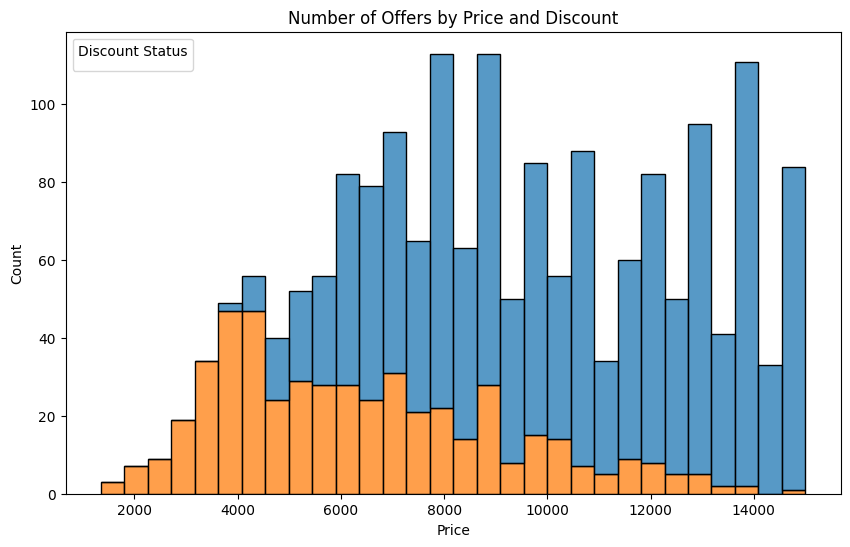

In [25]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='price',
    hue=df['discount'].apply(lambda x: 'Discounted' if x else 'Not Discounted'),
    multiple='stack',
    bins=30
)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Number of Offers by Price and Discount')
plt.legend(title='Discount Status')
plt.show()


In [26]:
html_df = df.copy()
localized_df = pd.read_csv(f"{LOCALIZED_PATH}", encoding="utf-8-sig")
localized_urls = set(localized_df['url'].str.lower().str.strip())

def make_clickable(url):
    url_norm = url.lower().strip()
    if url_norm in localized_urls:
        # Highlight: e.g. green, bold, underline
        return f'<a href="{url}" target="_blank">Nearby</a>'
    else:
        return f'<a href="{url}" target="_blank">Link</a>'

html_df['url'] = html_df['url'].apply(make_clickable)

# Select relevant columns
columns = ['title', 'price', 'year', 'mileage', 'discount', 'date', 'url']
html_table = html_df[columns].to_html(
    escape=False,
    index=False,
    justify='left',
    border=0,
    table_id="dealTable"
)

# HTML with sortable table support
html_output = f"""
<html>
<head>
    <title>Good car deals</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 2em; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ padding: 8px 12px; border: 1px solid #ccc; }}
        th {{ background-color: #f4f4f4; cursor: pointer; }}
        tr:nth-child(even) {{ background-color: #fafafa; }}
    </style>
</head>
<body>
    <h2>🚗 Good car deals: {len(df)} offers</h2>

    {html_table}

    <!-- DataTables CSS -->
    <link rel="stylesheet" href="https://cdn.datatables.net/1.13.6/css/jquery.dataTables.min.css">

    <!-- jQuery and DataTables JS -->
    <script src="https://code.jquery.com/jquery-3.7.0.min.js"></script>
    <script src="https://cdn.datatables.net/1.13.6/js/jquery.dataTables.min.js"></script>

    <script>
    $(document).ready(function(){{
        $('#dealTable').DataTable({{
            paging: false,
            info: false
        }});
    }});
    </script>
</body>
</html>
"""

# Save to file
with open("good_deals.html", "w", encoding="utf-8") as f:
    f.write(html_output)

print("✅ Exported to good_deals.html with sortable columns!")

    
import webbrowser
webbrowser.open("good_deals.html")

✅ Exported to good_deals.html with sortable columns!


True